In [1]:
import pandas as pd
import numpy as np
import re
from scipy import interp
import os
import string
import docx2txt
from docx import Document
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before Preprocessing: 0     Barbie movie wins box office battle in US The ...
1     Climate records tumble, leaving Earth in uncha...
2     The Ashes: England squad unchanged for final T...
3     Elon Musk: Twitter rebranded as X as blue bird...
4     Treasury to meet bank bosses over Farage row T...
5     UK venture capital firms failing to invest in ...
6      Weather satellite captures lightning spectacl...
7     Paris to bring back swimming in Seine after 10...
8     Greta Thunberg fined over Swedish climate prot...
9     Climate records tumble, leaving Earth in uncha...
10    Memo reveals pressure on UK climate finance pl...
11    Excessive heat: Why this summer has been so ho...
12    Women's World Cup: 'I had to sell sweets to ma...
13    Women's World Cup: 'I had to sell sweets to ma...
14    Women's World Cup: 'I had to sell sweets to ma...
15    Women's World Cup: 'I had to sell sweets to ma...
16    Sadio Mane: Bayern Munich forward considers of...
17    London Diamond Leagu

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

Decision_Tree Mean Metrics:
test_accuracy              0.711111
test_precision_weighted    0.666667
test_recall_weighted       0.711111
test_f1_weighted           0.674744
dtype: float64
  
Naive_Bayes Mean Metrics:
test_accuracy              0.477778
test_precision_weighted    0.487037
test_recall_weighted       0.477778
test_f1_weighted           0.440564
dtype: float64
  
Ridge_Classifier Mean Metrics:
test_accuracy              0.833333
test_precision_weighted    0.958333
test_recall_weighted       0.833333
test_f1_weighted           0.846296
dtype: float64
  
SVM_Classifier Mean Metrics:
test_accuracy              0.544444
test_precision_weighted    0.509259
test_recall_weighted       0.544444
test_f1_weighted           0.502787
dtype: float64
  


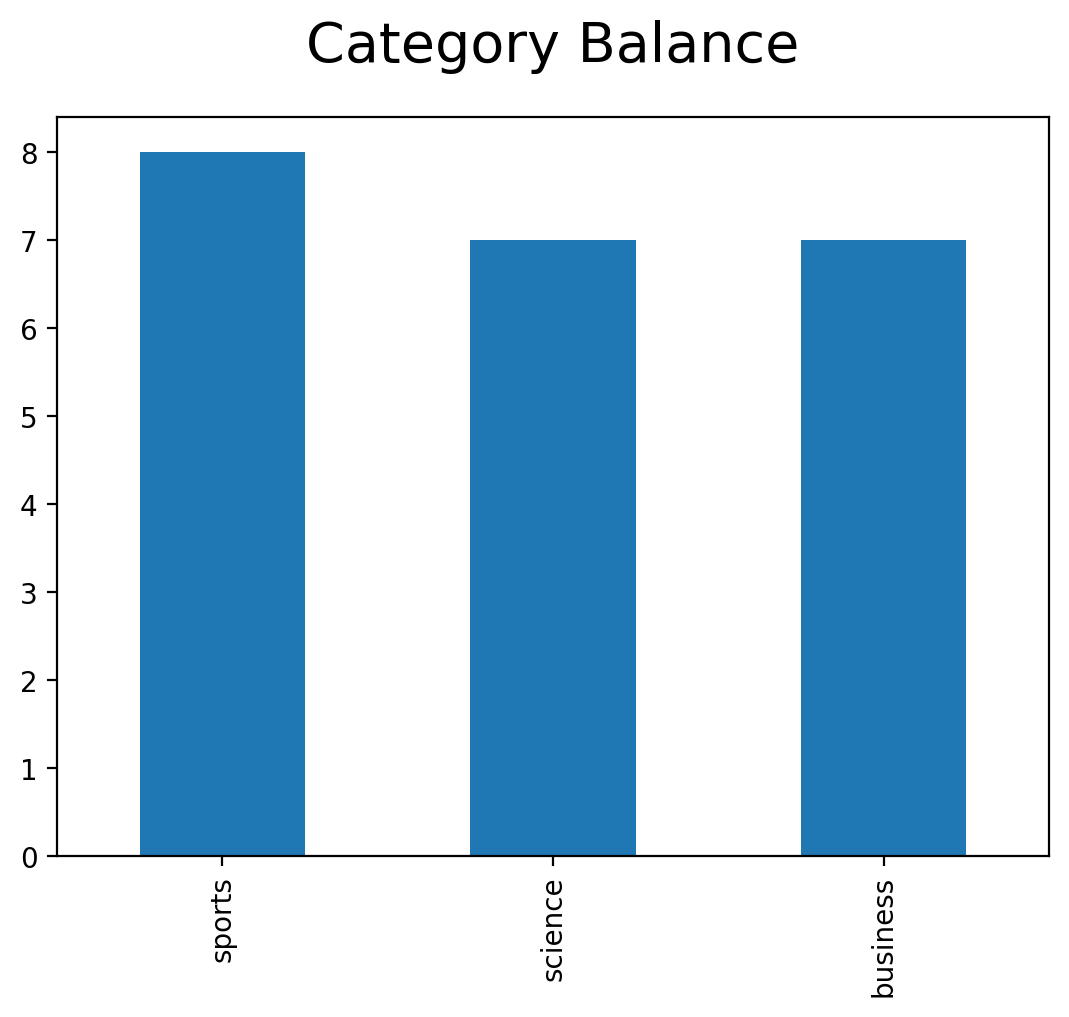

In [2]:
# To read the word documents and load it into .CSV file

def read_files_to_df(directory, category):
    news_df_path = 'news_df.csv'  
    if not os.path.exists(news_df_path): # If file does not exist create one
        news_df = pd.DataFrame(columns=["Class", "Text"])
    else: # If file exist read the file to news_df
        news_df = pd.read_csv(news_df_path, index_col=0)

    for filename in os.listdir(directory):
        if filename.startswith("~$") or not filename.endswith(".docx"):
            continue
        file_path = os.path.join(directory, filename)
        try:
            with open(file_path, "rb") as fileObject:
                document = Document(fileObject)
                data = " ".join([para.text for para in document.paragraphs])
        except Exception as e:
            print(f"Error while reading {file_path}: {e}")
            continue
        if data not in news_df['Text'].values:
            news_df = pd.concat([news_df, pd.DataFrame({"Class": [category], "Text": [data]})], ignore_index=True)
    news_df.to_csv(news_df_path, escapechar='\\')

# To set the directory for each category
business_directory = r'C:\Users\User\Business'
science_directory = r'C:\Users\User\Science'
sports_directory = r'C:\Users\User\Sports'

# To define categories
categories = ['business', 'science', 'sports']

# To read files from each directory and add them to the dataframe 
read_files_to_df(business_directory, categories[0])
read_files_to_df(science_directory, categories[1])
read_files_to_df(sports_directory, categories[2])

# To read the .CSV file back into a DataFrame
news_df_path = 'news_df.csv' 
news_df = pd.read_csv(news_df_path, index_col=0)


# To plot the distribution of data for each category
news_df['Class'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=20, pad=20);

# To Check for any missing values
news_df.isna().sum()


def preprocess(df, is_dataframe=True):
    stp_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN, "R": wordnet.ADV, "V": wordnet.VERB, "J": wordnet.ADJ}
        return hash_tag.get(tag, wordnet.NOUN)
    
    def lemmatize_text(text):
        tokens = nltk.word_tokenize(text)
        text = " ".join(lemmatizer.lemmatize(each, fwpt(each)) for each in tokens if each not in stp_words)
        return text
    
    if is_dataframe:
        df['preprocessed_text'] = df['Text'].replace('\n', ' ')
        df['preprocessed_text'] = df['preprocessed_text'].replace('\r', ' ')
        df['preprocessed_text'] = df['preprocessed_text'].str.lower()
        df['preprocessed_text'] = df['preprocessed_text'].str.translate(str.maketrans('', '', string.punctuation))
        df['final_text'] = df['preprocessed_text'].apply(lemmatize_text)
        return df
    else:
        text = df.replace('\n', ' ')
        text = text.replace('\r', ' ')
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = lemmatize_text(text)
        return text

print("Before Preprocessing:", news_df['Text'])
# This function will preprocess the "Text" and append it as a new column" final_text" to the existing dataframe
preprocess(news_df)
print("\nPreprocessed Data:", news_df['final_text'])

# To split the preprocessed data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(news_df['final_text'], 
                                                    news_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)
y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

def fit_model(Model, Model_name):
    score = Pipeline([('vectorize', vector), (Model_name, Model)])
    
    output = cross_validate(score, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    
    return output

# Initializing the classifiers
DTclassifier = DecisionTreeClassifier()
dtree_c = fit_model(DTclassifier, 'DTree')
RDclassifier = RidgeClassifier()
ridge_c = fit_model(RDclassifier, 'Ridge')
SVMclassifier = SVC()
svm_c = fit_model(SVMclassifier, 'SVM')
NBclassifer = MultinomialNB() 
bayes_c = fit_model(NBclassifer, 'NB')

dt = pd.DataFrame.from_dict(dtree_c)
rc = pd.DataFrame.from_dict(ridge_c)
svm = pd.DataFrame.from_dict(svm_c)
bc = pd.DataFrame.from_dict(bayes_c)

l1 = [bc, rc, svm, dt]
l2 =["NB", "Ridge","SVM", "DTree"]

for each, tag in zip(l1, l2):
    each['Model'] = [tag]*len(each)

final_output = pd.concat([bc,rc,svm,dt])

res_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = final_output.loc[final_output.Model == 'DTree'][res_measures]
nb_metrics = final_output.loc[final_output.Model == 'NB'][res_measures]
r_metrics = final_output.loc[final_output.Model == 'Ridge'][res_measures]
svm_metrics = final_output.loc[final_output.Model == 'SVM'][res_measures]

metrics_ = [dec_tree_metrics, nb_metrics, r_metrics, svm_metrics]
names_ = ['Decision_Tree', 'Naive_Bayes', 'Ridge_Classifier', 'SVM_Classifier']

for scores, names in zip(metrics_, names_):
    print(f'{names} Mean Metrics:')
    print(scores.mean())
    print('  ')
    
# To join both the testing and training dataset
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])
def best_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

# To fit the best best model
best_classifier = best_fit(MultinomialNB(), X, y)

In [3]:
import tkinter as tk
from tkinter import scrolledtext
from tkinter import END

def predict():
    """ This function is to predict the user_input
"""
    user_input = user_input_text.get(1.0, END).strip()
    if not user_input:
        result_text.config(state=tk.NORMAL)
        result_text.delete(1.0, END)
        result_text.insert(tk.INSERT, "Please enter a news article text.")
        result_text.config(state=tk.DISABLED)
        return
    print(" User Input Text before Preprocessing:", user_input)
    preprocessed_input = preprocess(user_input, is_dataframe = False)
    print("\n Preprocessed User Input Text:", preprocessed_input)
    predicted_class = best_classifier.predict([preprocessed_input])[0]

    result_text.config(state=tk.NORMAL)
    result_text.delete(1.0, END)
    result_text.insert(tk.INSERT, f"Predicted class: {predicted_class}")
    result_text.config(state=tk.DISABLED)

# To create the application window
root_window = tk.Tk()
root_window.title("TEXT CLASSIFIER")

# To create text box and label for user input
user_input_label = tk.Label(root_window, text="Enter a news article text:")
user_input_label.pack()
user_input_text = scrolledtext.ScrolledText(root_window, width=40, height=5, wrap=tk.WORD)
user_input_text.pack()

# To create a button 'Predict'
predict_button = tk.Button(root_window, text="Predict", command=predict)
predict_button.pack()

# To create a text widget for displaying the result
result_text = scrolledtext.ScrolledText(root_window, width=40, height=3, wrap=tk.WORD, state=tk.DISABLED)
result_text.pack()

root_window.mainloop()


 User Input Text before Preprocessing: the temparture is so hot today

 Preprocessed User Input Text: temparture hot today
 User Input Text before Preprocessing: the climate is so hot today

 Preprocessed User Input Text: climate hot today
